In [1]:
import os

city = "Stadt_Heidelberg"
folder = f'./data/processed/cycle_counter/{city}'
files = os.listdir(folder)

In [2]:
import pandas as pd

def import_data(station):
    df = pd.read_csv(f'{folder}/{station}.csv')

    df['iso_timestamp'] = pd.to_datetime(df['iso_timestamp'], utc=True, errors='coerce')
    df['iso_timestamp'].dropna()
    df['iso_timestamp'] = df['iso_timestamp'].dt.tz_convert('Europe/Berlin')
    
    station_name = df['counter_site'][0]
    
    return station_name, df

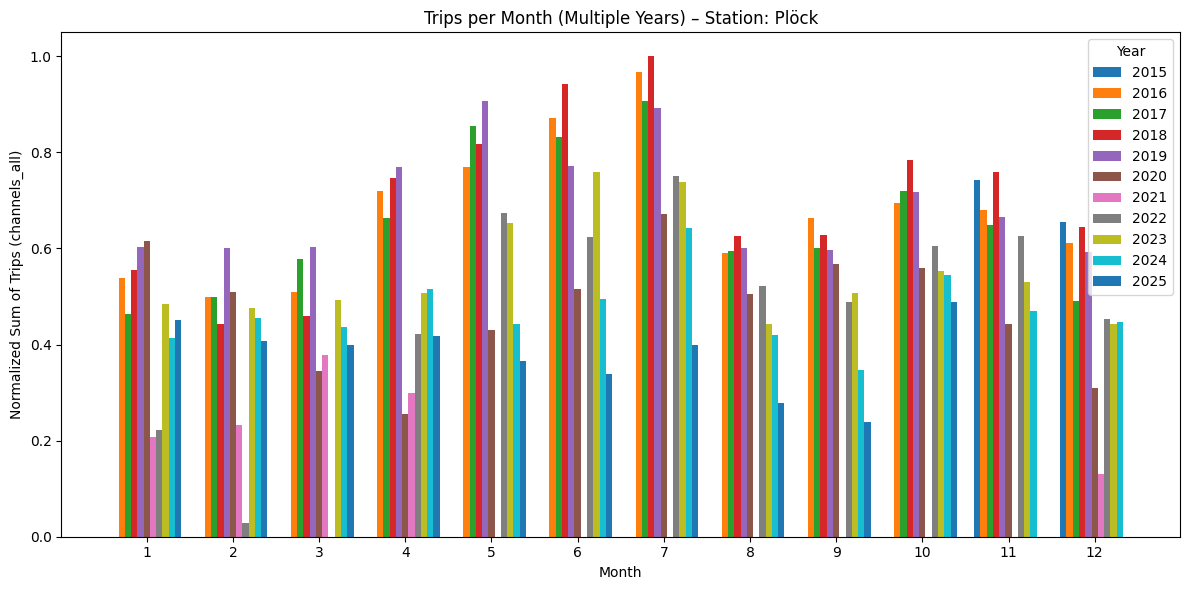

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_monthly_sums_by_year(station):
    station_name, df = import_data(station)
    df['year'] = df['iso_timestamp'].dt.year
    df['month'] = df['iso_timestamp'].dt.month

    data = {}
    for year, year_df in df.groupby('year'):
        for month, month_df in year_df.groupby('month'):
            sum_channels = month_df['channels_all'].sum()
            data[(month, year)] = sum_channels

    years = sorted(set(year for (month, year) in data.keys()))
    months = range(1, 13)
    max_value = max(data.values()) if data else 1

    values_per_year = {
        year: [data.get((month, year), 0) for month in months]
        for year in years
    }

    bar_width = 0.8 / len(years) if years else 0.8

    plt.figure(figsize=(12, 6))
    for i, year in enumerate(years):
        positions = np.array(months) - 1 + i * bar_width
        plt.bar(positions, values_per_year[year] / max_value, width=bar_width, label=str(year))

    plt.xlabel('Month')
    plt.ylabel('Normalized Sum of Trips (channels_all)')
    plt.title(f'Trips per Month (Multiple Years) – Station: {station_name}')
    plt.xticks(np.arange(12) + bar_width * (len(years)-1)/2, months)
    plt.legend(title='Year')
    plt.tight_layout()
    plt.show()

# Use by station name
plot_monthly_sums_by_year('station_100012161')

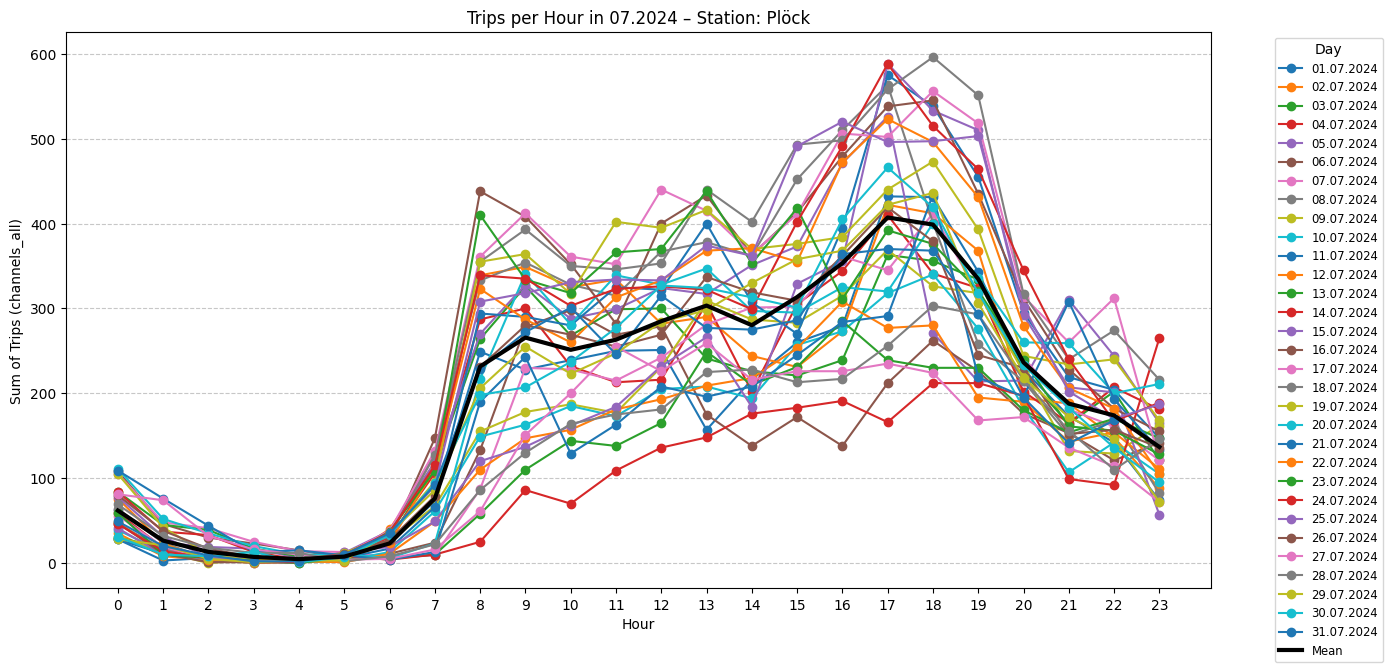

In [4]:
import matplotlib.pyplot as plt

def plot_daily_hourly_curves_by_month(station, year, month):
    station_name, df = import_data(station)
    mask = (df['iso_timestamp'].dt.year == year) & (df['iso_timestamp'].dt.month == month)
    df_month = df[mask]

    plt.figure(figsize=(14, 7))

    # For each day in the month, plot hourly sums
    for day in sorted(df_month['iso_timestamp'].dt.day.unique()):
        df_day = df_month[df_month['iso_timestamp'].dt.day == day]
        hourly = df_day.groupby(df_day['iso_timestamp'].dt.hour)['channels_all'].sum()
        plt.plot(hourly.index, hourly.values, marker='o', label=f'{day:02d}.{month:02d}.{year}')

    # Calculate mean per hour over the month
    mean_hourly = df_month.groupby(df_month['iso_timestamp'].dt.hour)['channels_all'].mean()
    plt.plot(mean_hourly.index, mean_hourly.values, color='black', linewidth=3, label='Mean')

    plt.xlabel('Hour')
    plt.ylabel('Sum of Trips (channels_all)')
    plt.title(f'Trips per Hour in {month:02d}.{year} – Station: {station_name}')
    plt.xticks(range(0, 24))
    plt.legend(title='Day', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example call:
plot_daily_hourly_curves_by_month('station_100012161', 2024, 7)

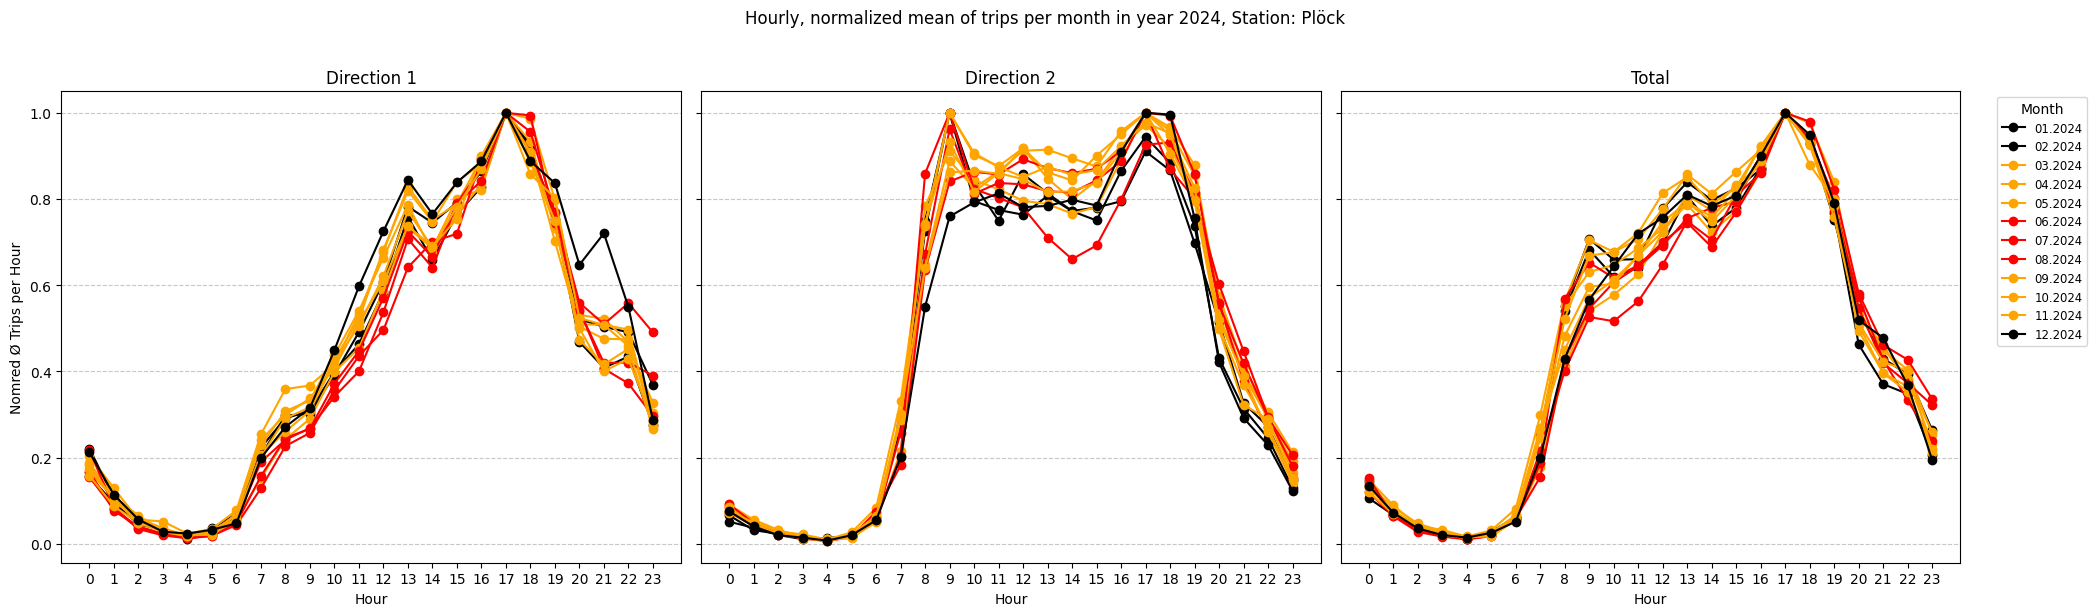

In [5]:
import matplotlib.pyplot as plt

def plot_hourly_means_by_month(station, year):
    station_name, df = import_data(station)
    
    def get_color(month):
        if month in [6, 7, 8]:
            return 'red'
        elif month in [12, 1, 2]:
            return 'black'
        else:
            return 'orange'

    cols = ['channels_in', 'channels_out', 'channels_all']
    titles = ['Direction 1', 'Direction 2', 'Total']

    fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
    for ax, col, title in zip(axes, cols, titles):
        for month in sorted(df[df['iso_timestamp'].dt.year == year]['iso_timestamp'].dt.month.unique()):
            mask = (df['iso_timestamp'].dt.year == year) & (df['iso_timestamp'].dt.month == month)
            df_month = df[mask]
            mean_hourly = df_month.groupby(df_month['iso_timestamp'].dt.hour)[col].mean()
            max_value = mean_hourly.max()
            ax.plot(
                mean_hourly.index,
                mean_hourly.values / max_value if max_value != 0 else mean_hourly.values,
                marker='o',
                label=f'{month:02d}.{year}',
                color=get_color(month)
            )
        
        ax.set_xlabel('Hour')
        ax.set_title(f'{title}')
        ax.set_xticks(range(0, 24))
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].set_ylabel('Nomred Ø Trips per Hour')
    axes[-1].legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    fig.suptitle(f'Hourly, normalized mean of trips per month in year {year}, Station: {station_name}', y=1.02)
    plt.tight_layout()
    plt.show()

# Example call:
plot_hourly_means_by_month('station_100012161', 2024)

['station_100050030', 'station_100013034', 'station_100048812', 'station_100049883', 'station_100048813', 'station_100048811', 'station_100048814', 'station_100049901', 'station_100056770', 'station_100012608', 'station_100059184', 'station_100012161', 'station_100059187', 'station_100056769', 'station_100050750']


/tmp/ipykernel_5519/2695979091.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[-1].legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')


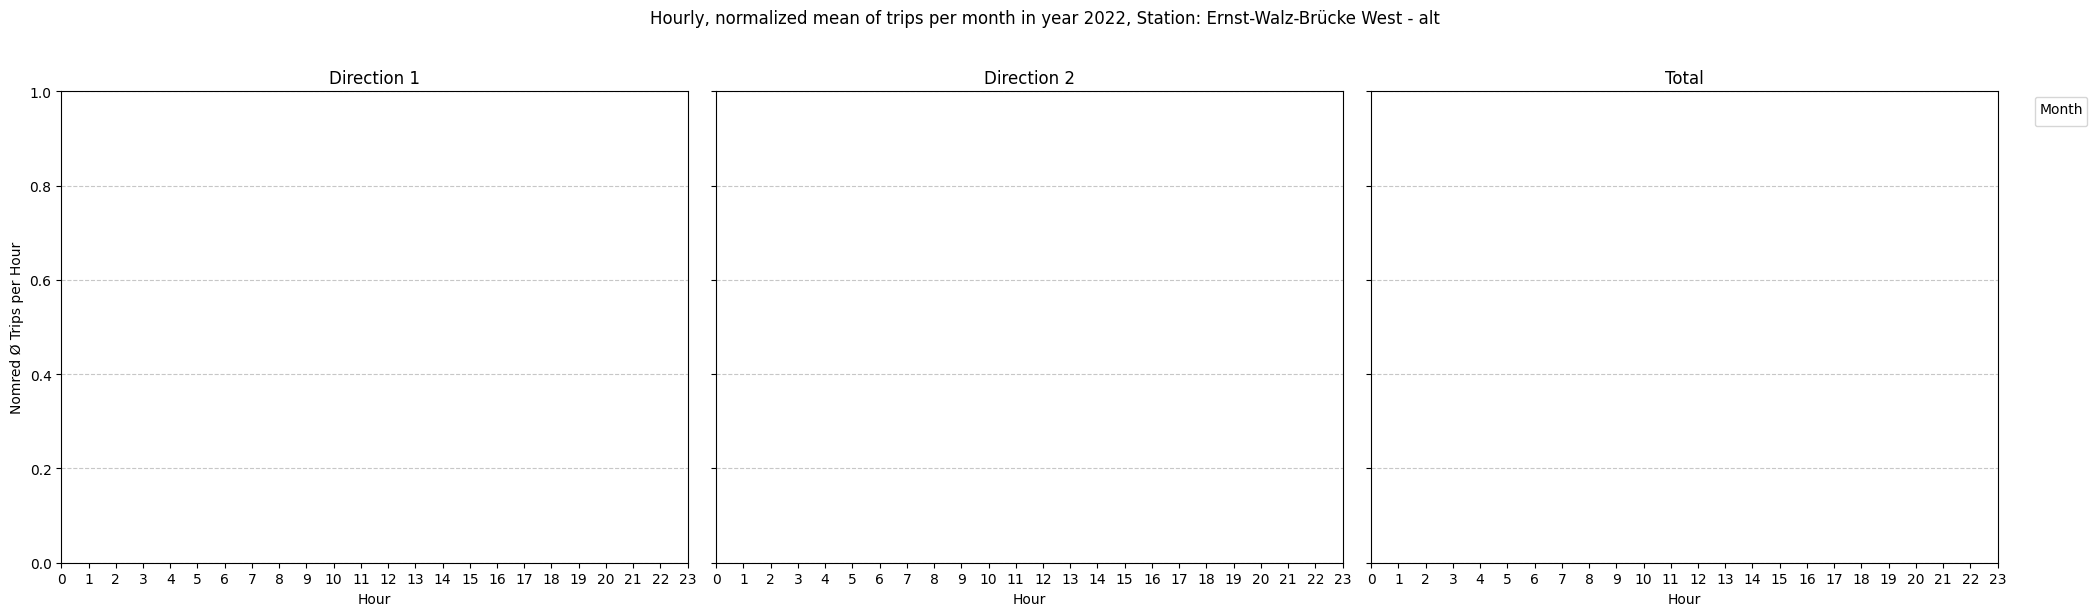

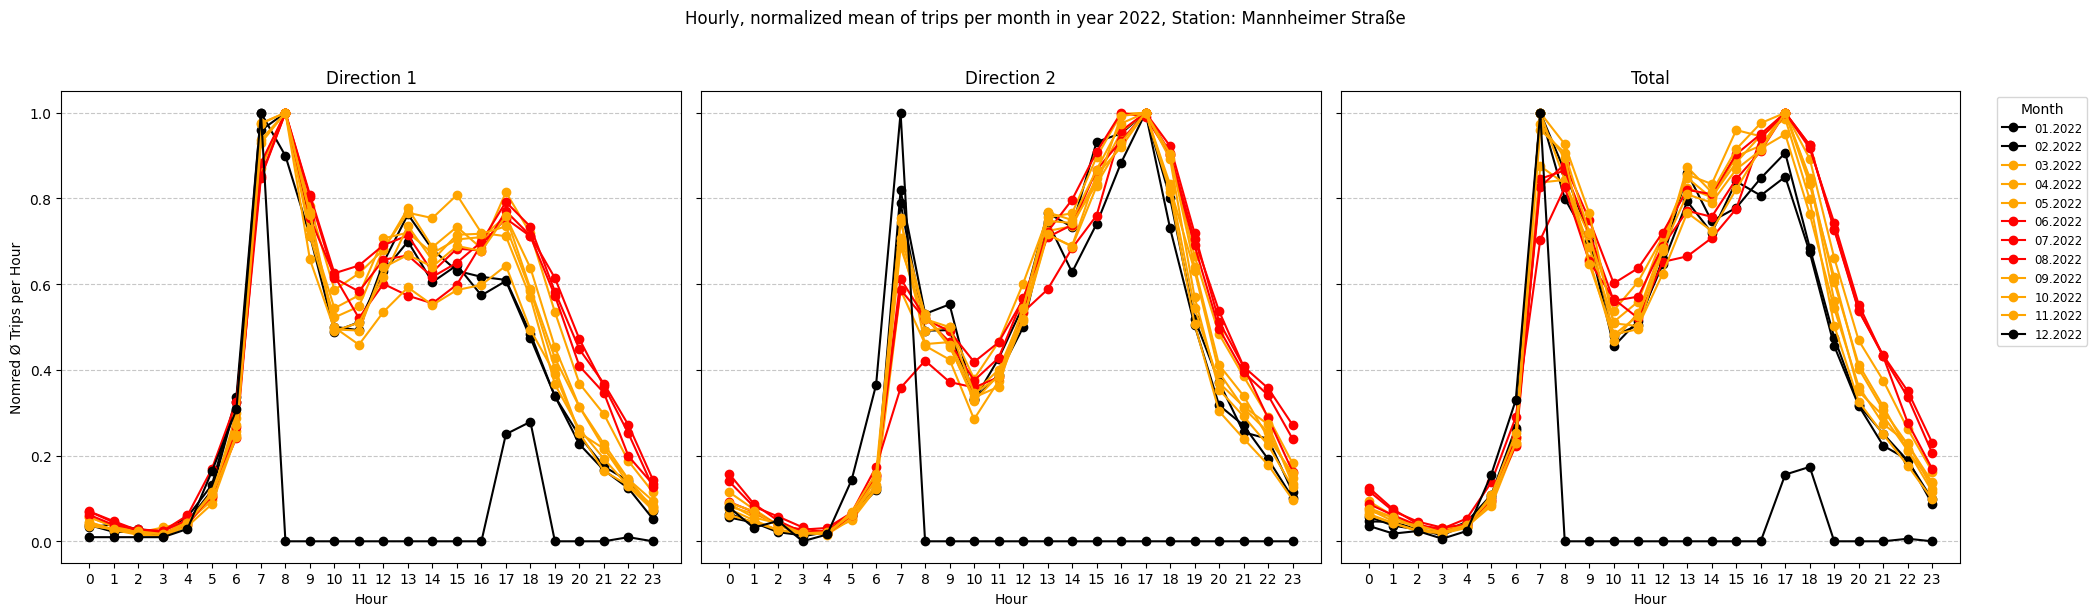

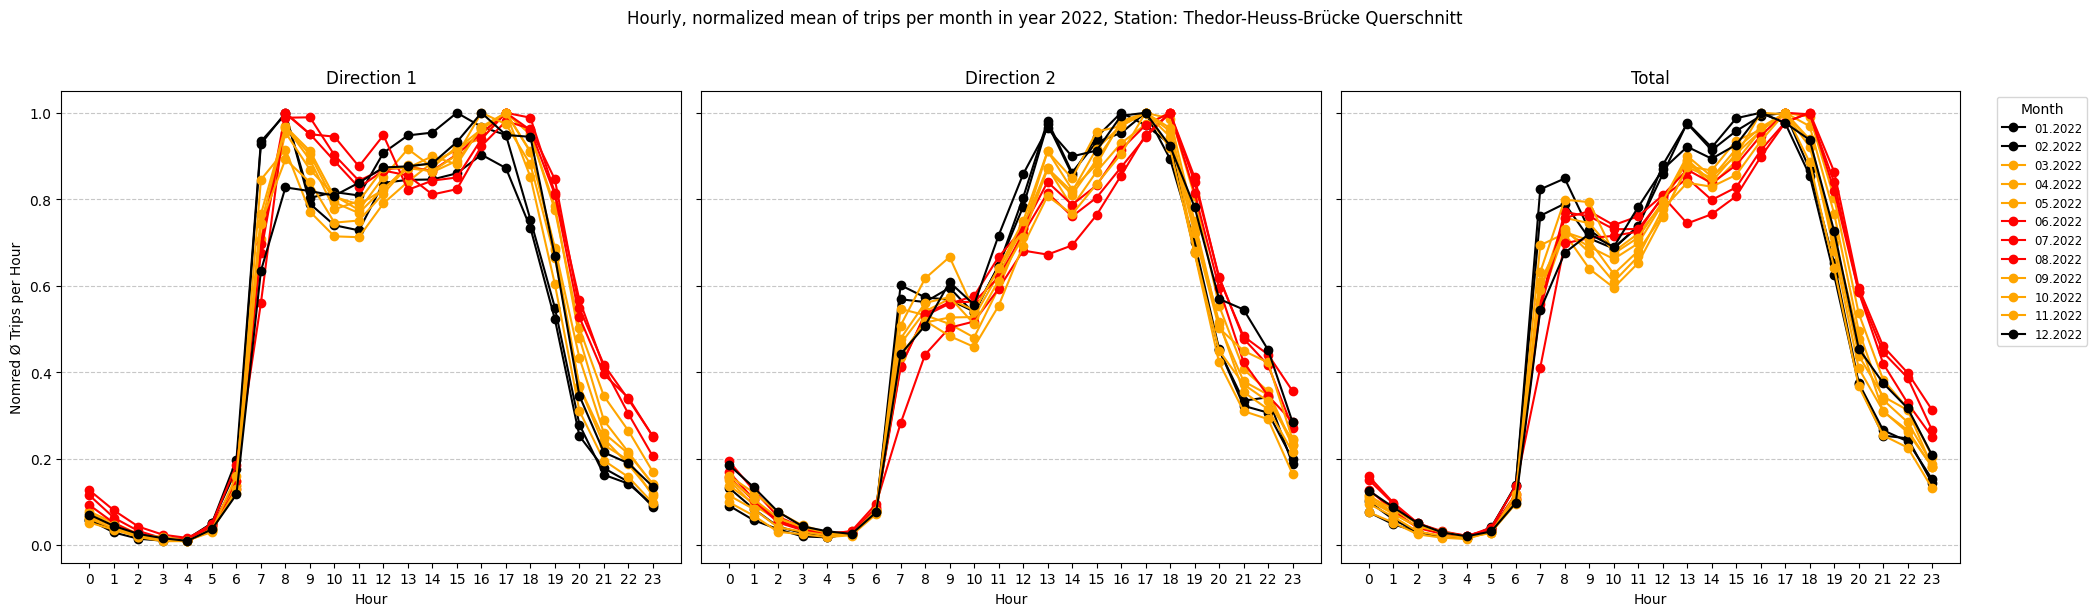

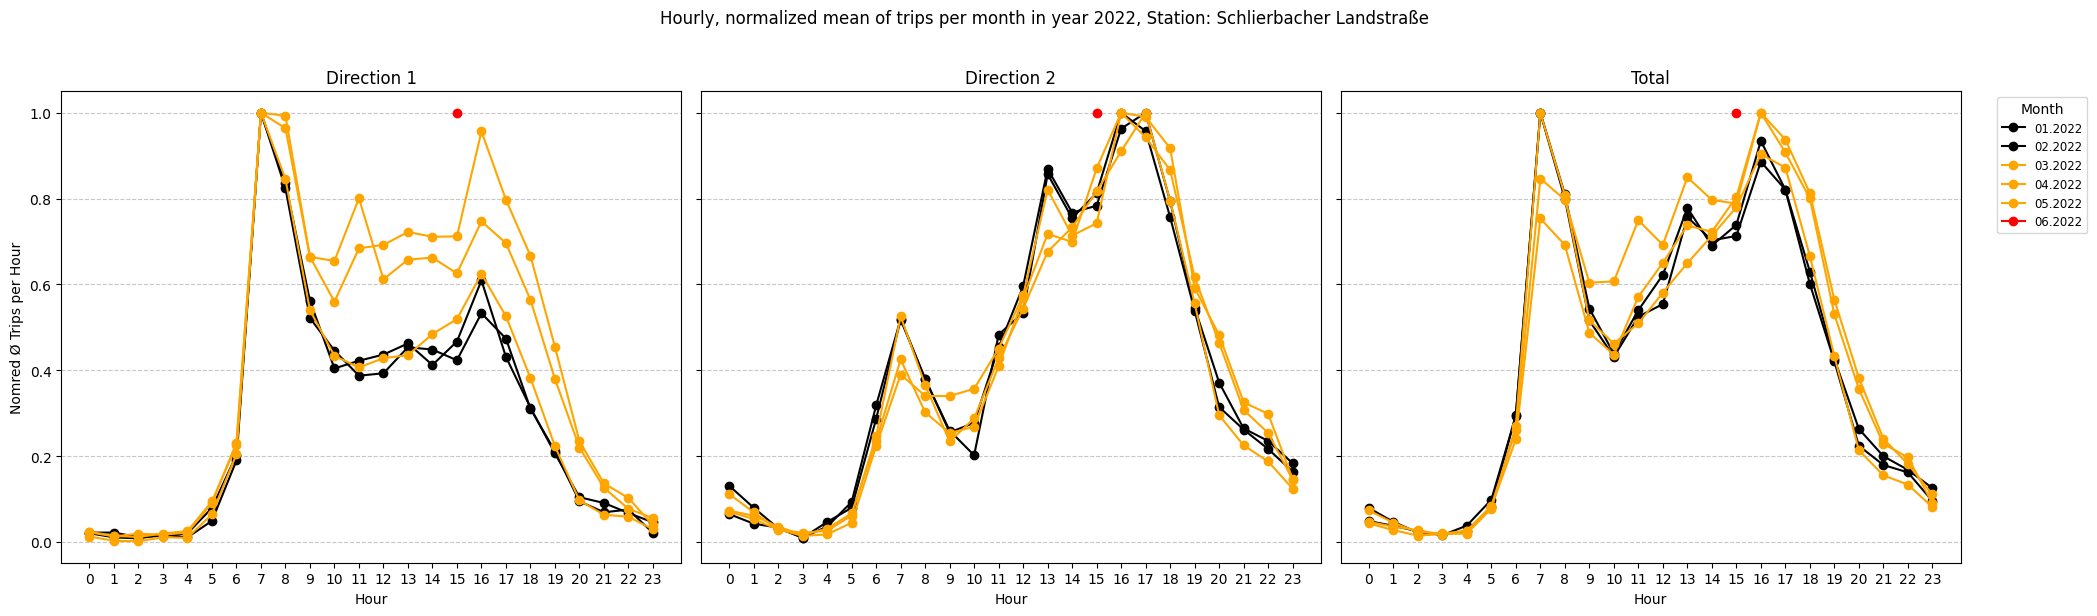

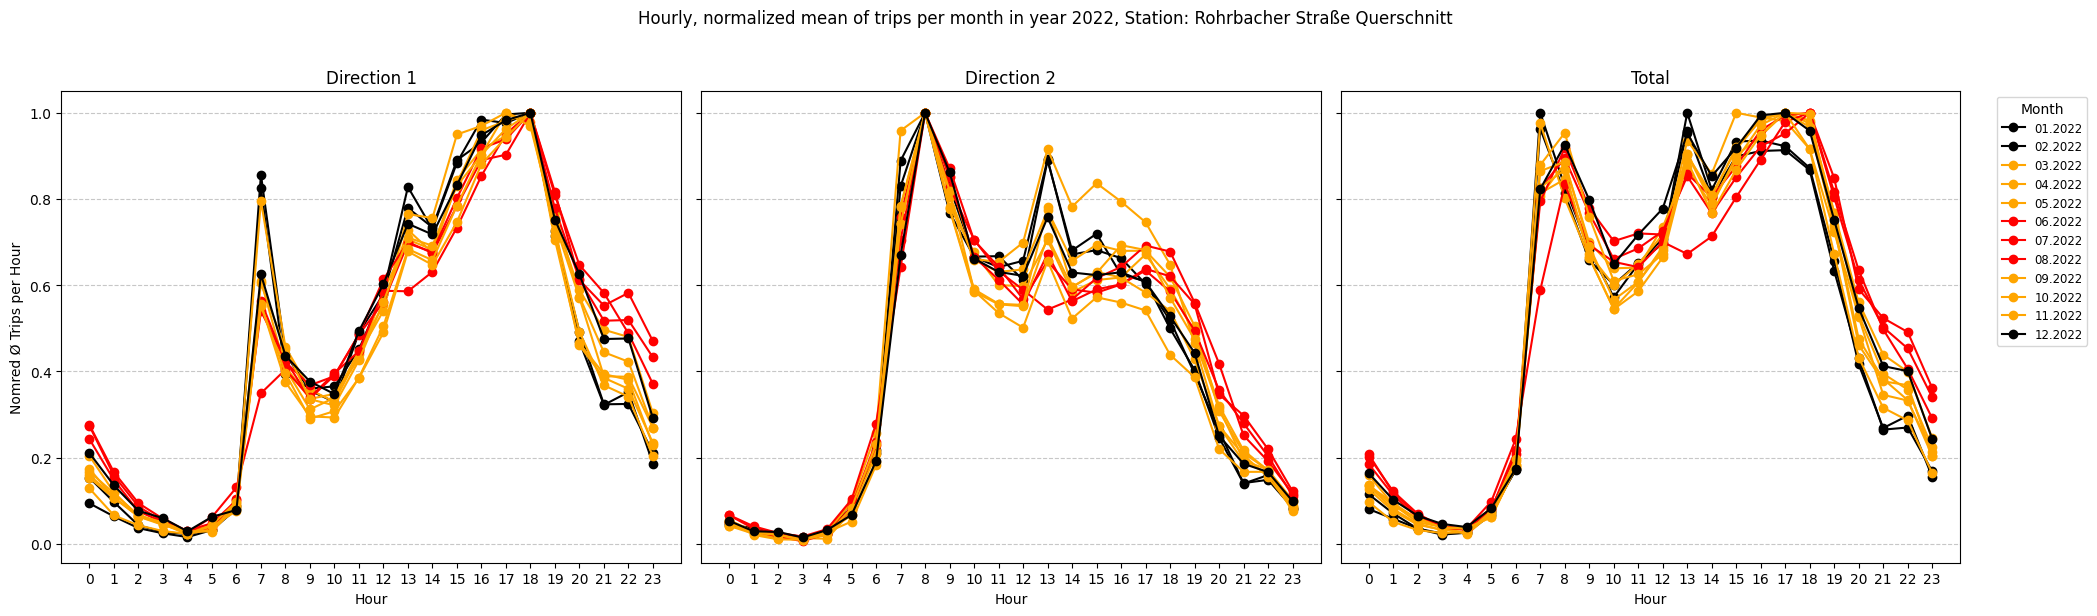

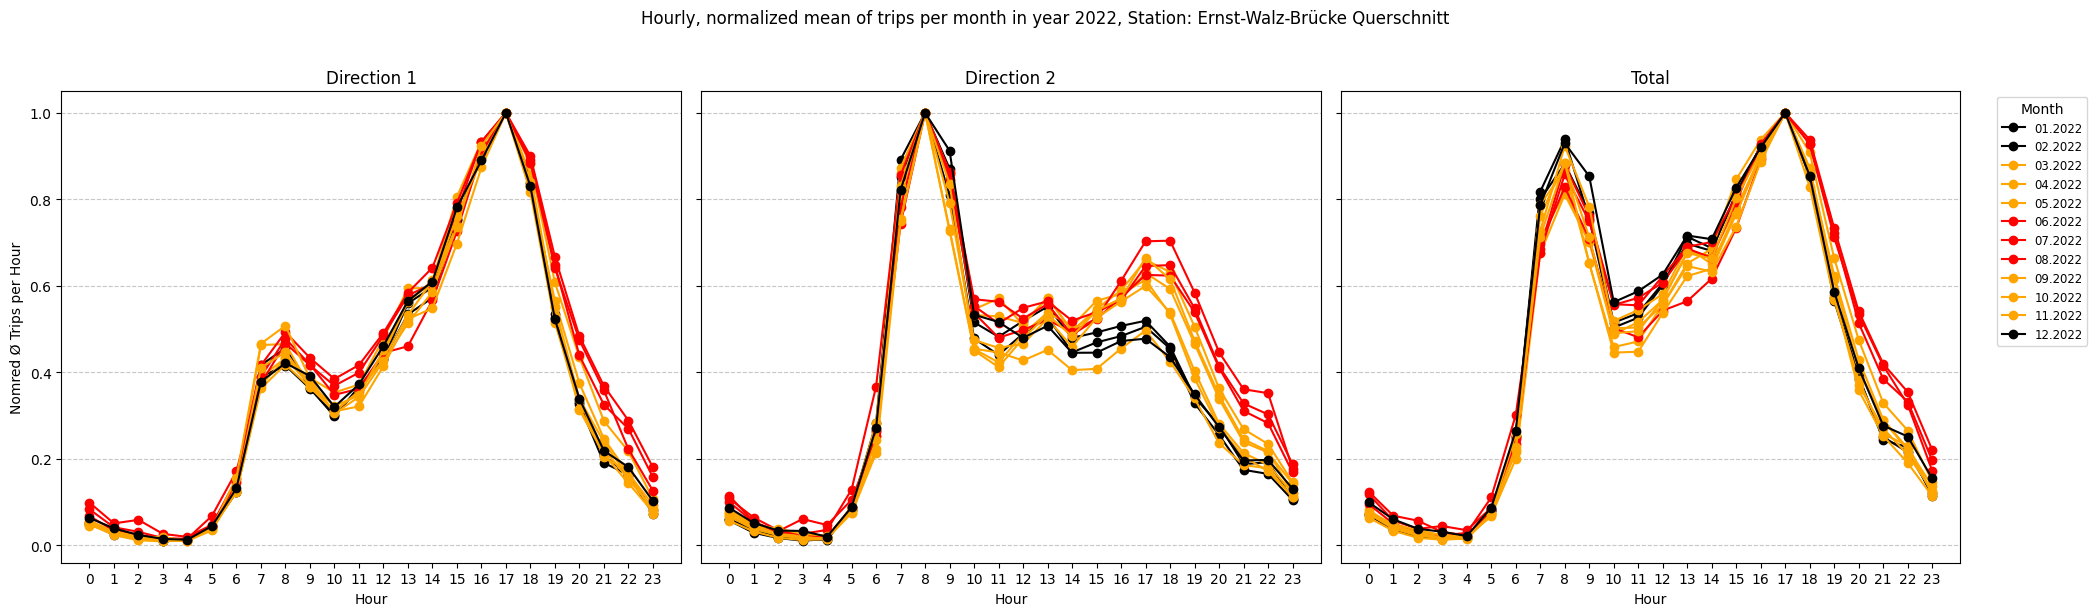

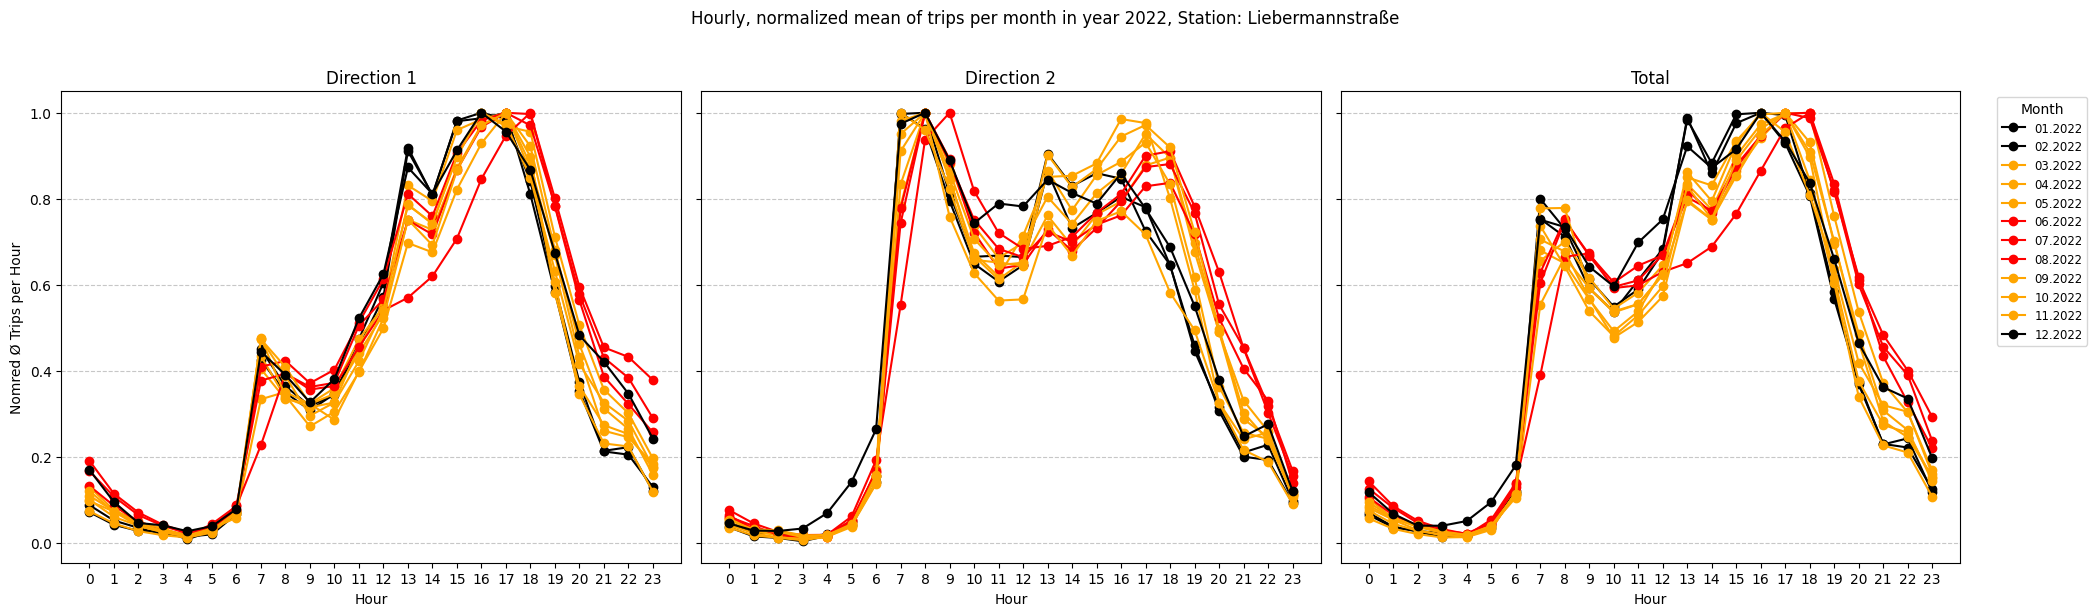

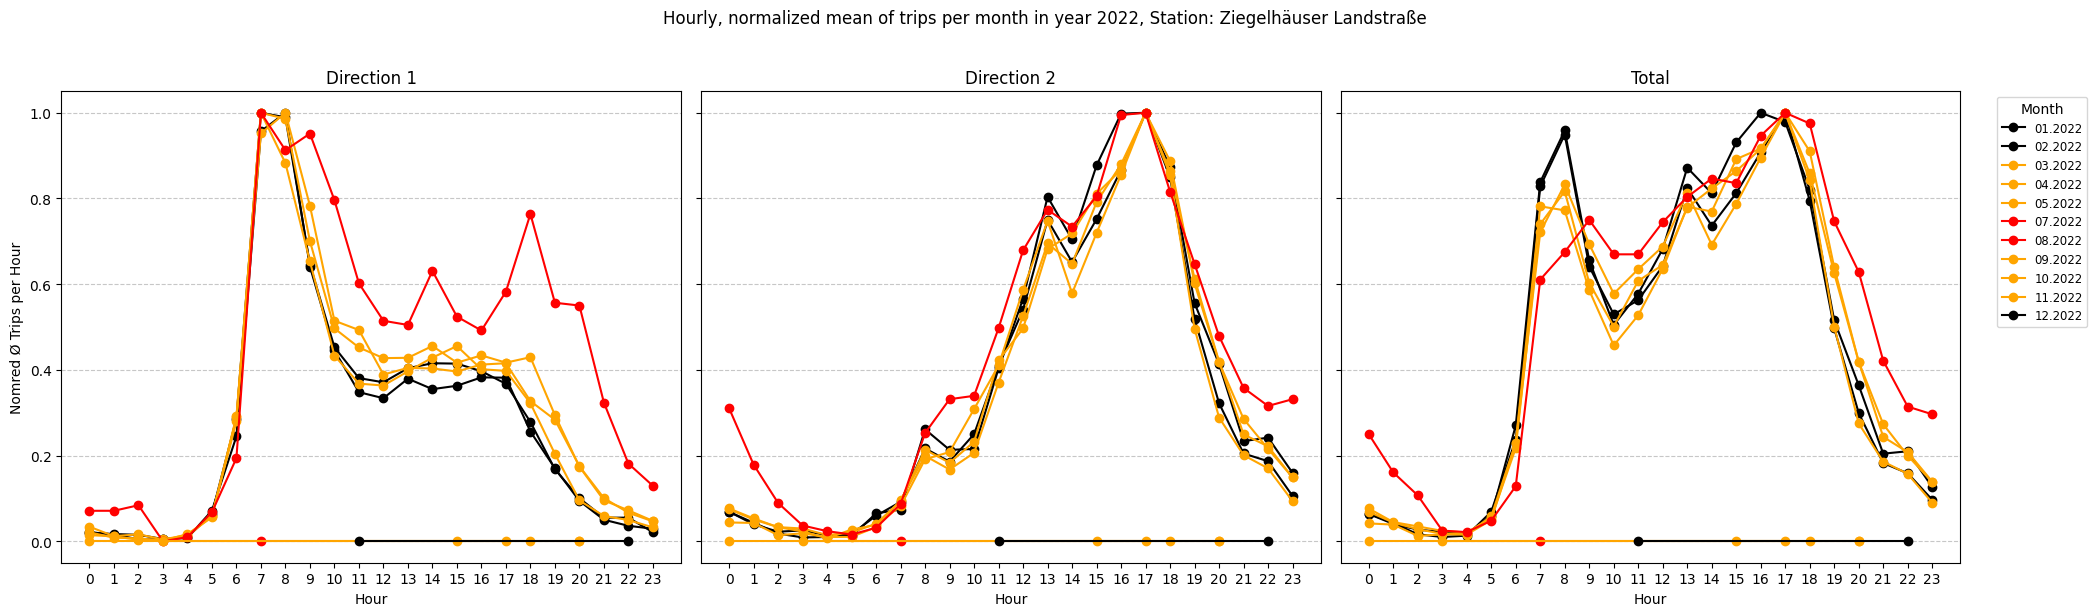

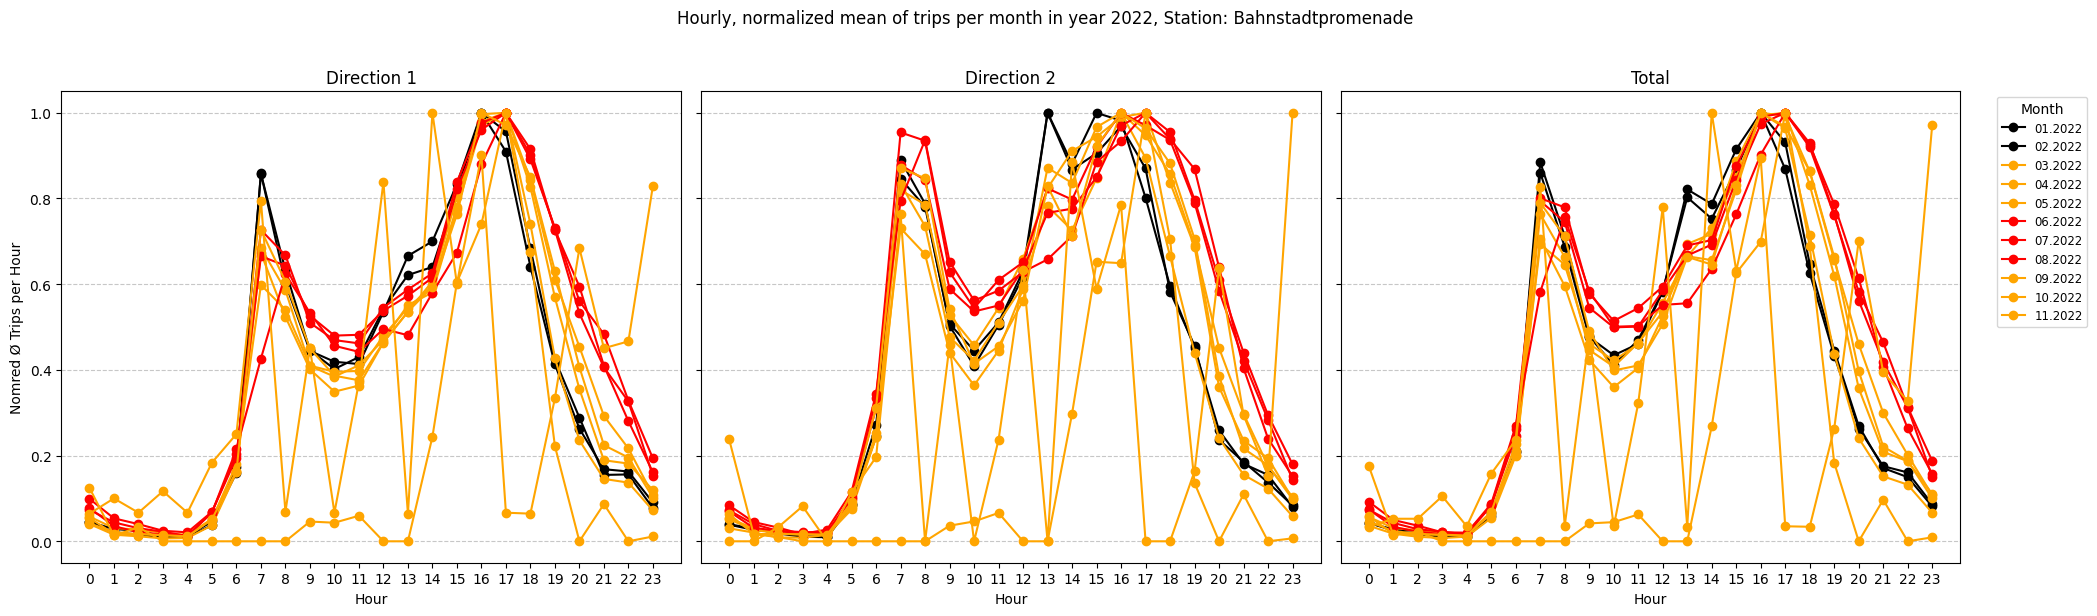

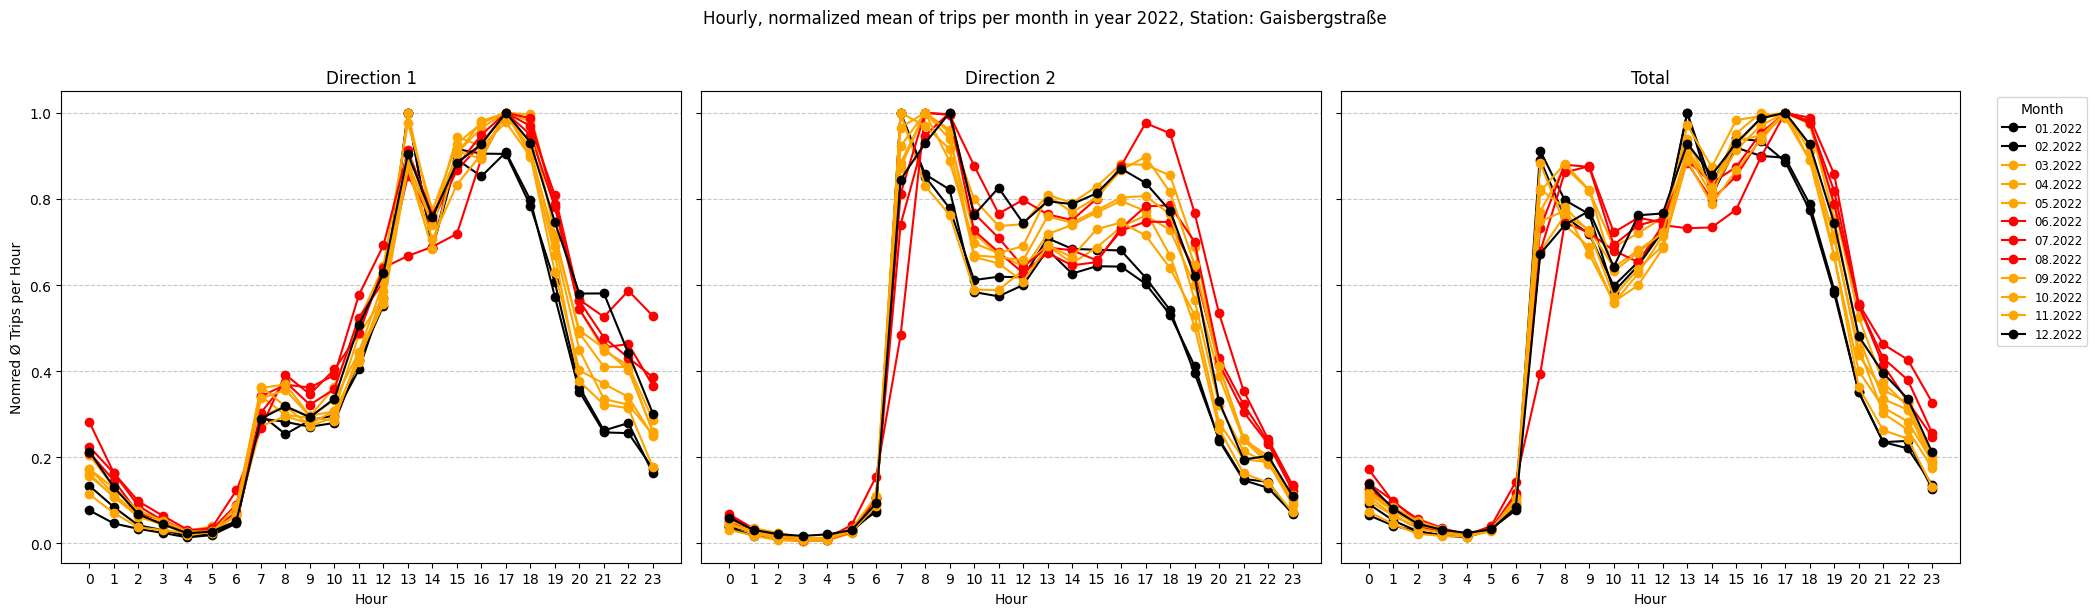

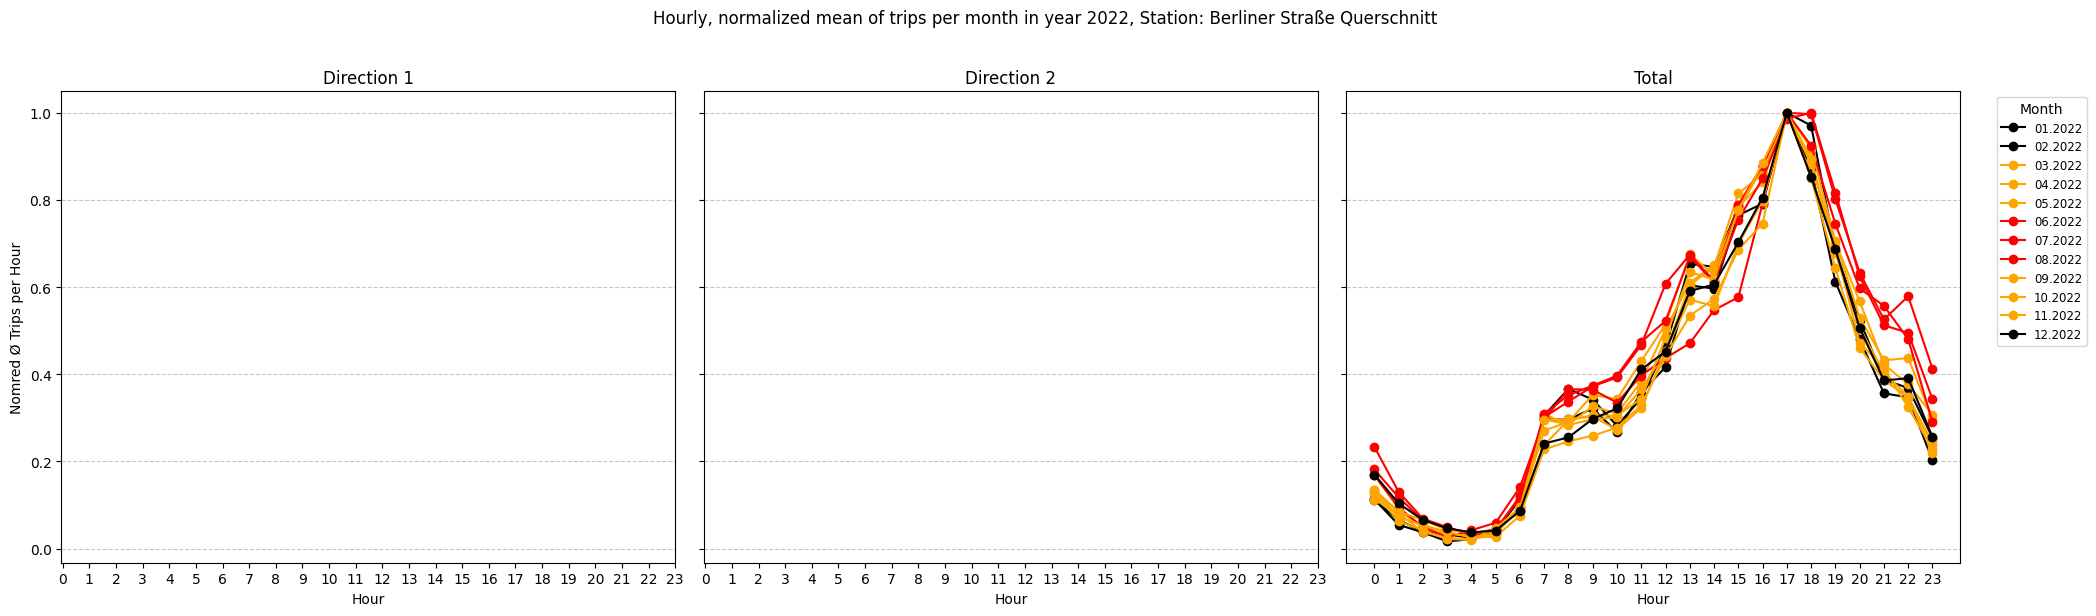

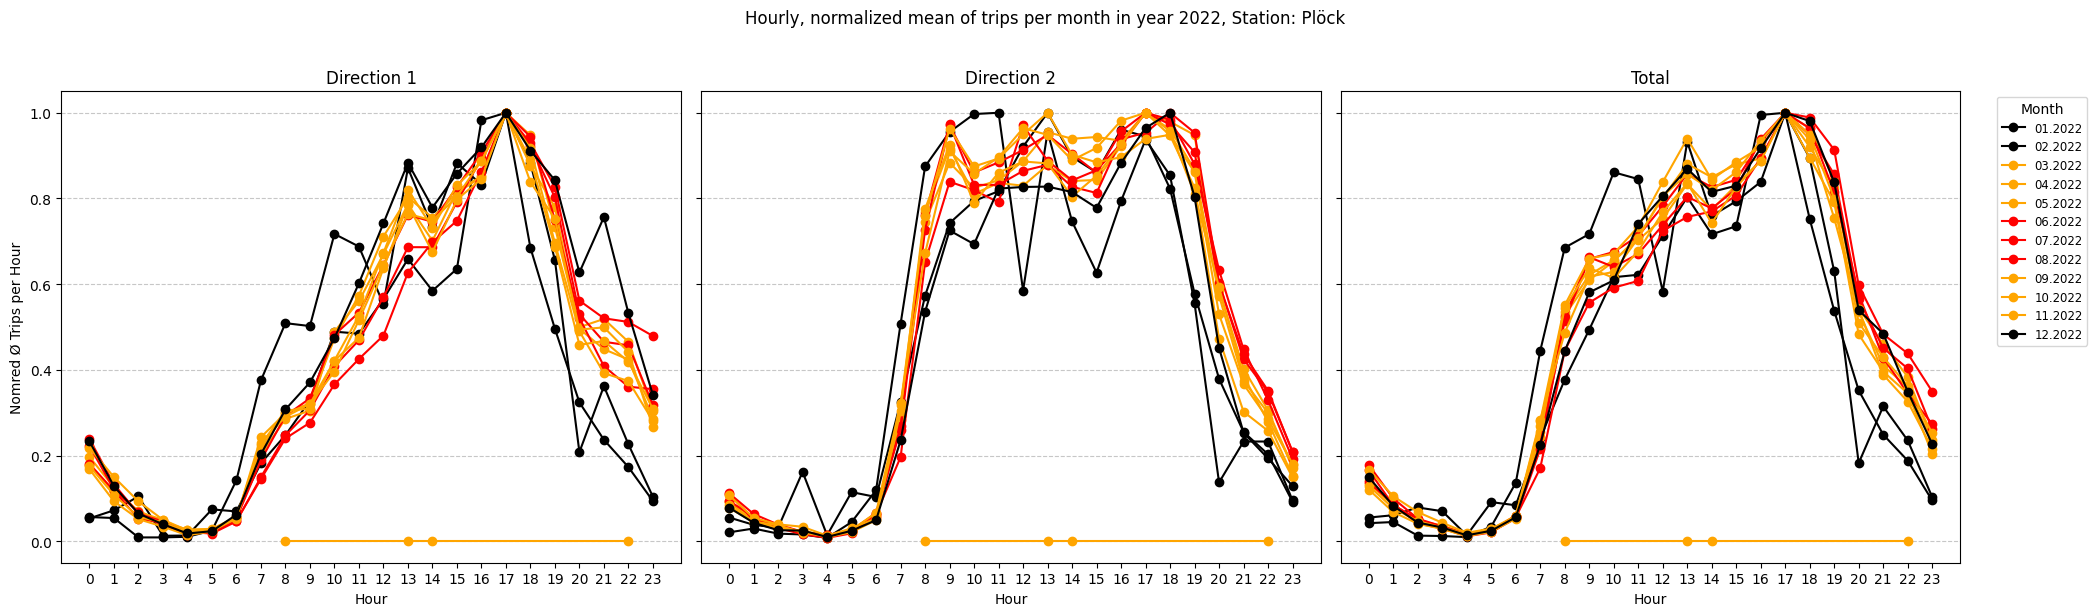

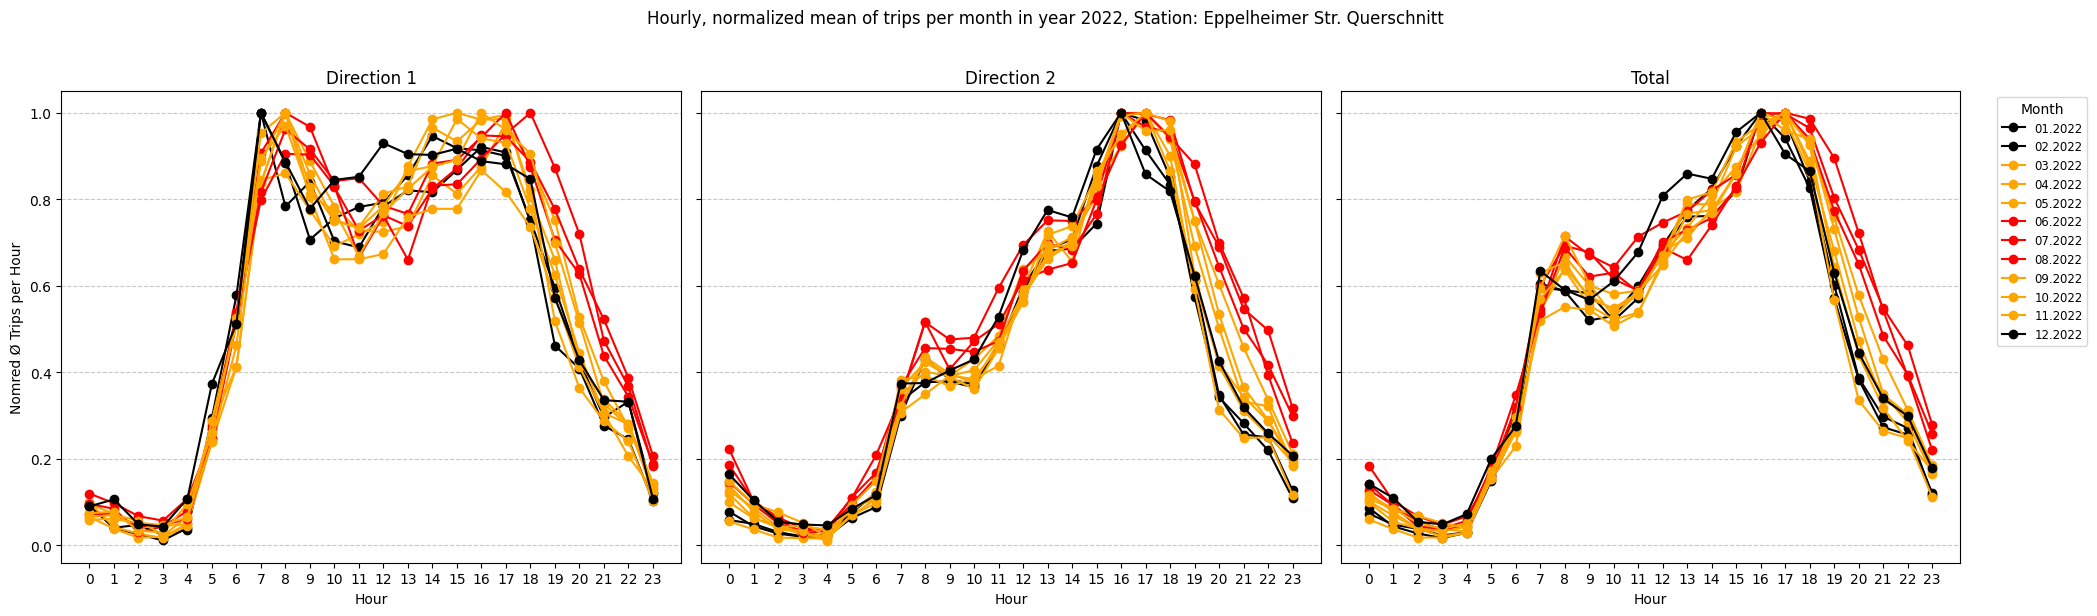

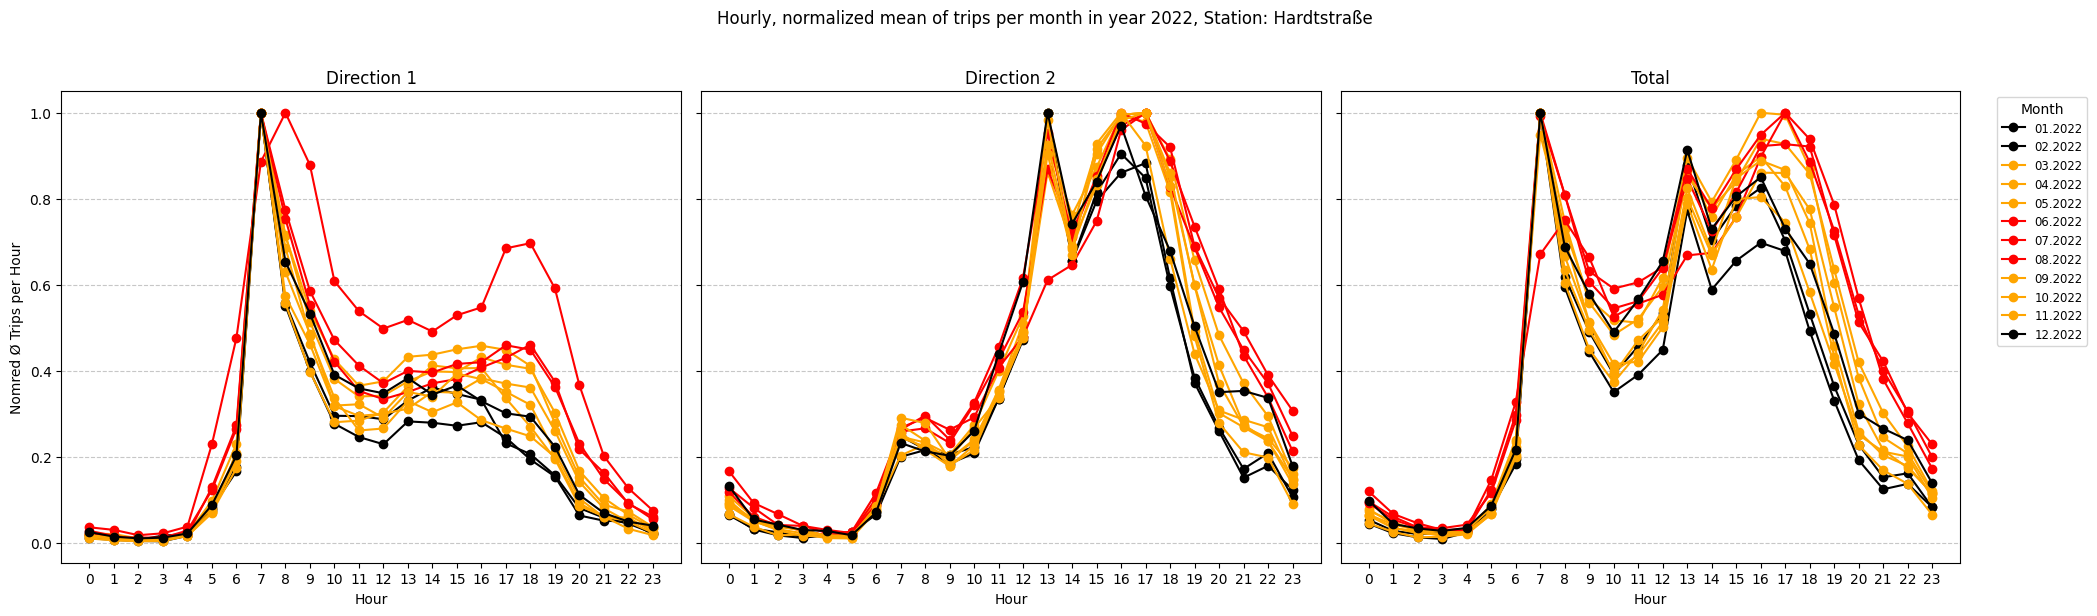

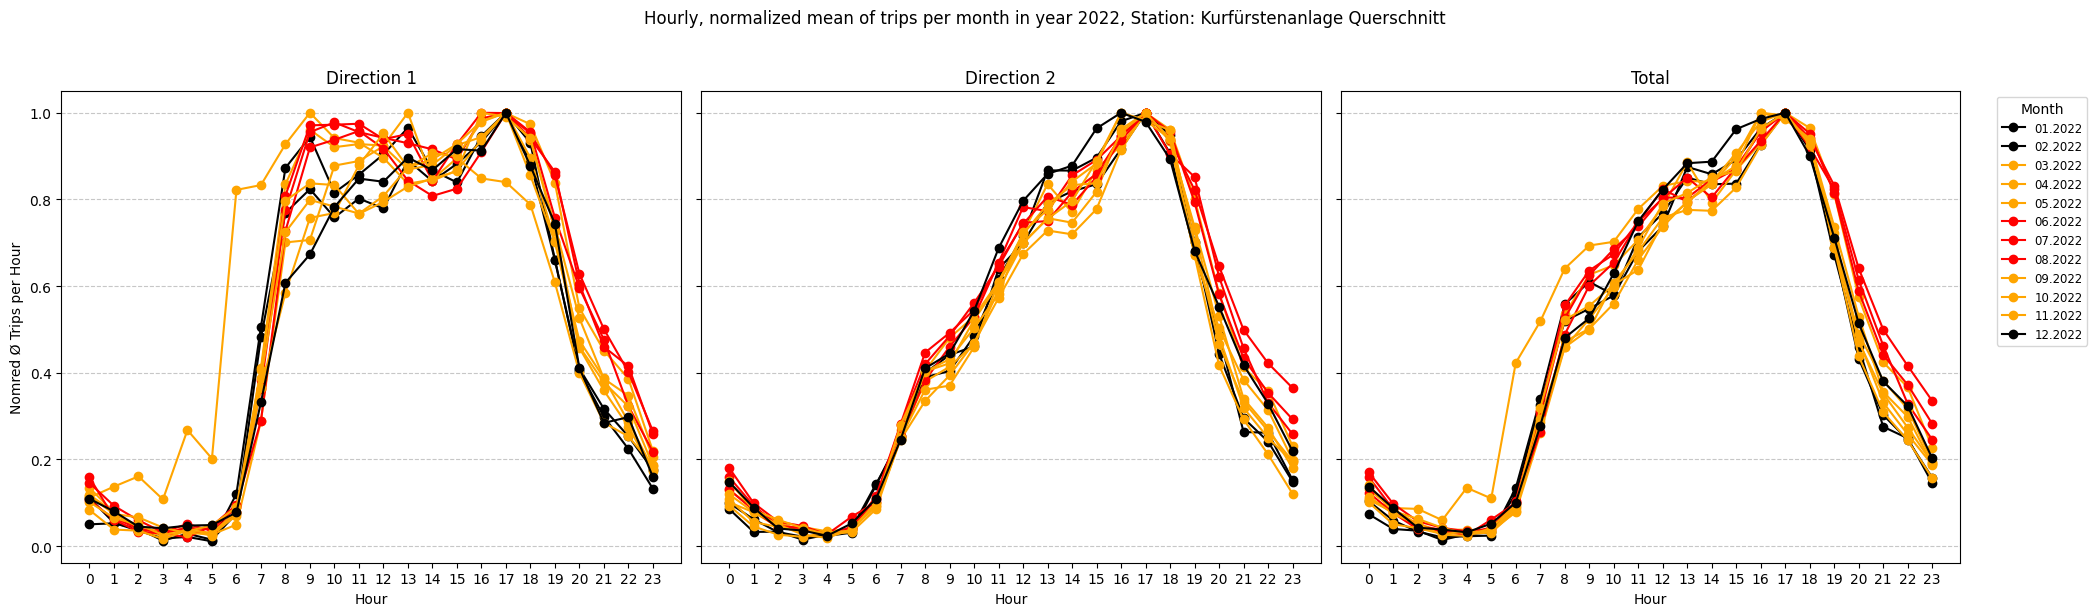

In [6]:
stations = [f[:-4] for f in files if f.endswith('.csv')]

print(stations)

# Create plots
for station in stations:
    plot_hourly_means_by_month(station, 2022)

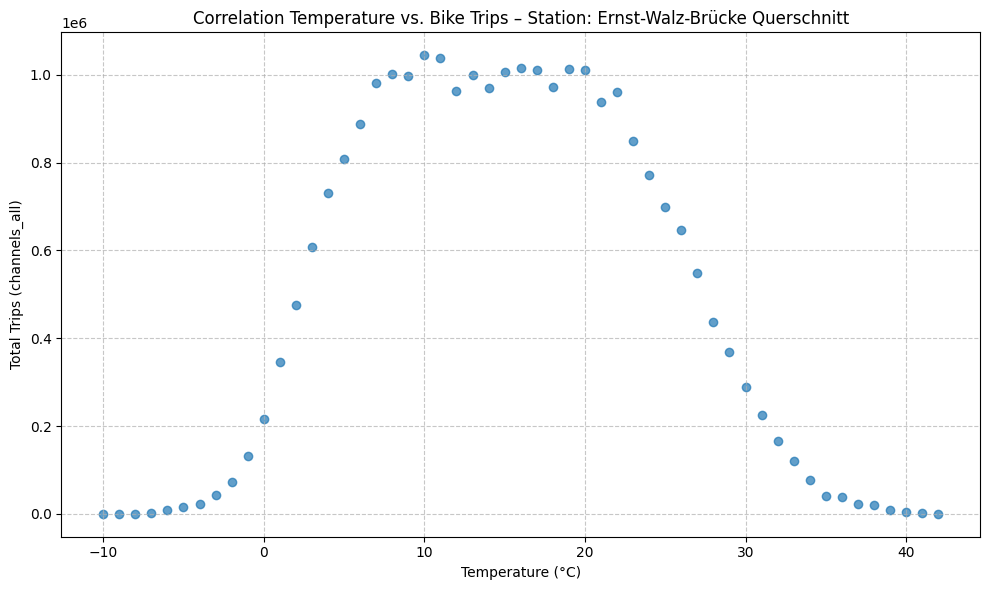

In [7]:
import matplotlib.pyplot as plt

def plot_temp_vs_bikecount(station):
    station_name, df = import_data(station)

    df['site_temperature'] = pd.to_numeric(df['site_temperature'], errors='coerce')
    df = df.dropna(subset=['site_temperature', 'channels_all'])
    df['site_temperature'] = df['site_temperature'].round()
    grouped = df.groupby('site_temperature')['channels_all'].sum().reset_index()

    plt.figure(figsize=(10, 6))
    plt.scatter(grouped['site_temperature'], grouped['channels_all'], alpha=0.7)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Total Trips (channels_all)')
    plt.title(f'Correlation Temperature vs. Bike Trips – Station: {station_name}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Beispielaufruf:
plot_temp_vs_bikecount('station_100048811')

In [8]:
import folium
import os
import pandas as pd

locations = []

for file in files:
    df = pd.read_csv(os.path.join(folder, file))
    if 'latitude' in df.columns and 'longitude' in df.columns:
        lat = df['latitude'].iloc[0]
        lon = df['longitude'].iloc[0]
        name = df['counter_site'].iloc[0] if 'counter_site' in df.columns else file[:-4]
        if pd.notna(lat) and pd.notna(lon):
            locations.append((lat, lon, name))

avg_lat = sum([loc[0] for loc in locations]) / len(locations)
avg_lon = sum([loc[1] for loc in locations]) / len(locations)

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=13)

for lat, lon, name in locations:
    folium.Marker([lat, lon], popup=name).add_to(m)

m

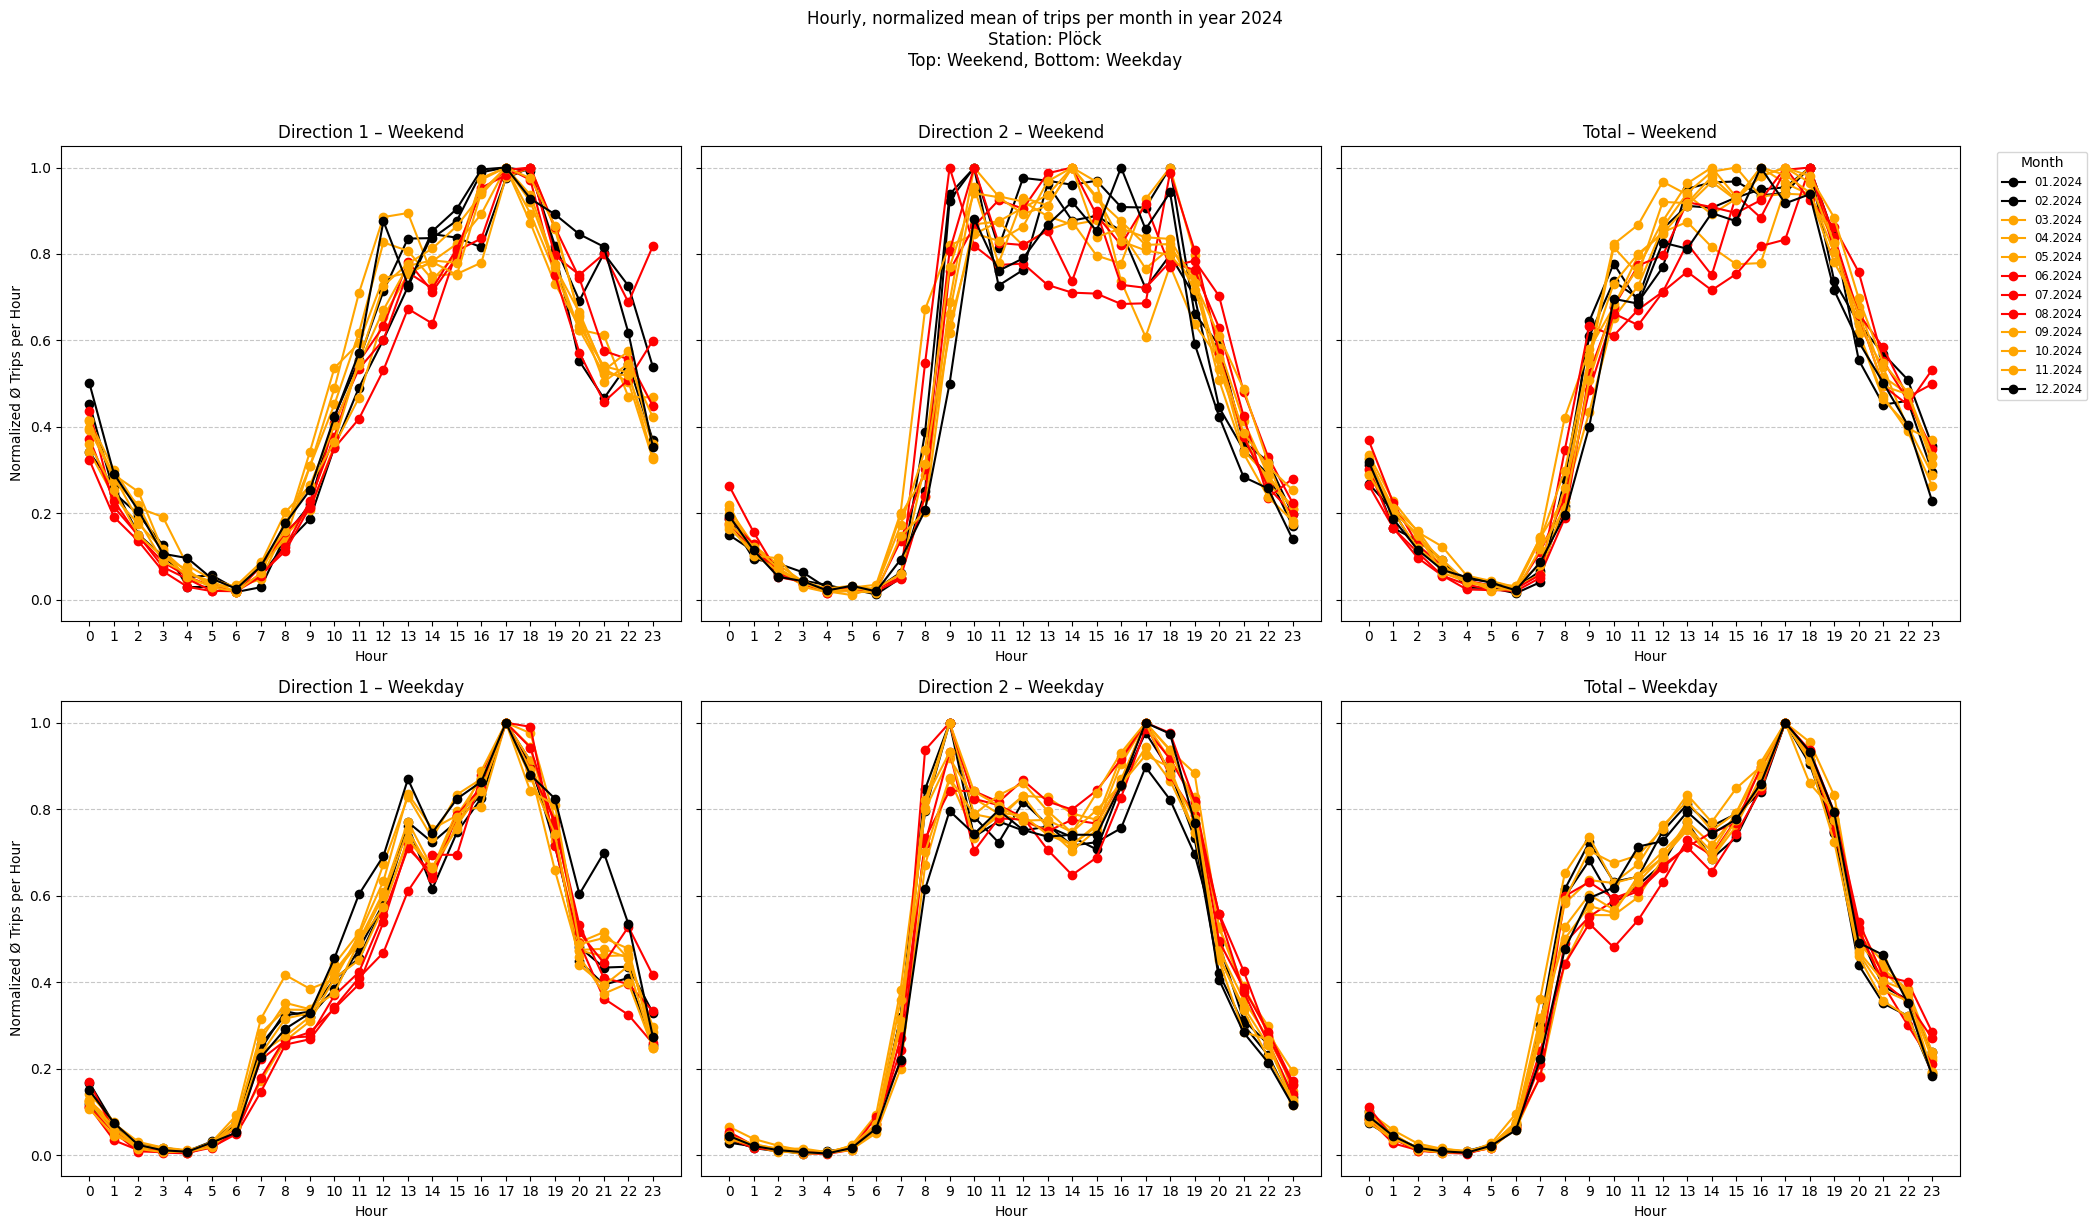

In [9]:
import matplotlib.pyplot as plt

def plot_hourly_means_weekend_weekday(station, year):
    station_name, df = import_data(station)
    df['weekday'] = df['iso_timestamp'].dt.weekday  # 0=Montag, ..., 6=Sonntag

    def get_color(month):
        if month in [6, 7, 8]:
            return 'red'
        elif month in [12, 1, 2]:
            return 'black'
        else:
            return 'orange'

    cols = ['channels_in', 'channels_out', 'channels_all']
    titles = ['Direction 1', 'Direction 2', 'Total']

    fig, axes = plt.subplots(2, 3, figsize=(21, 12), sharey=True)
    for row, daytype in enumerate(['Weekend', 'Weekday']):
        for ax, col, title in zip(axes[row], cols, titles):
            for month in sorted(df[df['iso_timestamp'].dt.year == year]['iso_timestamp'].dt.month.unique()):
                mask_month = (df['iso_timestamp'].dt.year == year) & (df['iso_timestamp'].dt.month == month)
                if daytype == 'Weekend':
                    mask = mask_month & (df['weekday'] >= 5)  # Saturday (5) & Sunday (6)
                else:
                    mask = mask_month & (df['weekday'] < 5)   # Monday-Friday (0-4)
                df_sel = df[mask]
                if df_sel.empty:
                    continue
                mean_hourly = df_sel.groupby(df_sel['iso_timestamp'].dt.hour)[col].mean()
                max_value = mean_hourly.max()
                ax.plot(
                    mean_hourly.index,
                    mean_hourly.values / max_value if max_value != 0 else mean_hourly.values,
                    marker='o',
                    label=f'{month:02d}.{year}',
                    color=get_color(month)
                )
            ax.set_xlabel('Hour')
            ax.set_title(f'{title} – {daytype}')
            ax.set_xticks(range(0, 24))
            ax.grid(axis='y', linestyle='--', alpha=0.7)
    axes[0,0].set_ylabel('Normalized Ø Trips per Hour')
    axes[1,0].set_ylabel('Normalized Ø Trips per Hour')
    axes[0,-1].legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    fig.suptitle(f'Hourly, normalized mean of trips per month in year {year}\nStation: {station_name}\nTop: Weekend, Bottom: Weekday', y=1.02)
    plt.tight_layout()
    plt.show()

# Example call:
plot_hourly_means_weekend_weekday('station_100012161', 2024)